# Resampled Stats Example

See my [gist with functions here](https://gist.github.com/spestana/93682fecb659a8013e6c853b2630c15e).

---

Import required packages

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import xarray as xr

# for plotting
import matplotlib.pyplot as plt

Define the functions

In [2]:
def compute_modes(resampled, n=0):
    
    '''Given a resampled xarray object (xarray.core.resample.DataArrayResample),
       compute the modes ( rounding values with np.round(_,n) ), 
       return a pandas dataframe with the modes, counts, and groups (datetime)'''
    
    # Compute modes
    resampled_ModeResults = [stats.mode(np.round(x[1],n)) for x in resampled]
    
    # Get all the modes
    resampled_modes = [x.mode for x in resampled_ModeResults]
    # Reshape result into 1D array
    resampled_modes = np.array(resampled_modes).reshape(len(resampled))
    
    # Get the count for each mode
    resampled_counts = [x.count for x in resampled_ModeResults]
    # Reshape result into 1D array
    resampled_counts = np.array(resampled_counts).reshape(len(resampled))
    
    # Get the group (datetime) for each mode
    resampled_groups = np.array( list(resampled.groups.keys()) )
    
    # Create pandas dataframe
    d = {'modes': resampled_modes, 'counts': resampled_counts}
    df = pd.DataFrame(data=d, index=resampled_groups)
    
    return df

def resampled_stats(resampled, n=0):
    
    '''Given a resampled xarray object (xarray.core.resample.DataArrayResample),
    return a pandas dataframe with the mean, median, modes, counts, and groups (datetime)'''
    
    # Compute modes
    resampled_modes = compute_modes(resampled, n)
    
    # Compute and add mean, medians, modes, counts to a dataframe
    d = {'means': resampled.mean().values, 
         'medians': resampled.median().values, 
         'modes': resampled_modes.modes.values,
         'counts': resampled_modes.counts.values,
         'maxs': resampled.max().values,
         'mins': resampled.min().values,
         'ranges': resampled.max().values - resampled.min().values,
         'stds': resampled.std().values,}
    
    df = pd.DataFrame(data=d, index=resampled_modes.index)
    
    return df

Open a data file

In [3]:
cues_ds = pd.read_pickle('data/goes-cues_2017-2020.pkl')
# squeeze out extra dimension after xarray dataset conversion
cues_ds = cues_ds.to_xarray().squeeze()
# compute difference value between GOES Tb and CUES Tss
cues_ds['goes_cues_diff'] = cues_ds.goes_tb_c - cues_ds['snow surface temperature; Apogee SI-111 thermal radiometer; (Celsius)']

## Monthly groupby example

In [4]:
resampled_month = cues_ds.goes_cues_diff.where(cues_ds.cloud_flag==0).groupby("datetime.month")

In [5]:
resampled_month_df = resampled_stats(resampled_month, 0)

In [6]:
resampled_month_df.head()

,means,medians,modes,counts,maxs,mins,ranges,stds
1,-2.722015,2.364767,4.0,1442,15.981127,-55.774201,71.755328,13.270174
2,3.149673,4.853243,4.0,1551,15.807728,-52.936379,68.744107,8.622994
3,-0.490177,2.397673,2.0,1460,16.838511,-63.529734,80.368245,10.686069
4,-0.301482,2.595912,3.0,2439,14.881764,-56.601961,71.483725,9.287855
5,0.091498,2.664780,2.0,2017,32.726410,-57.685058,90.411467,9.622706


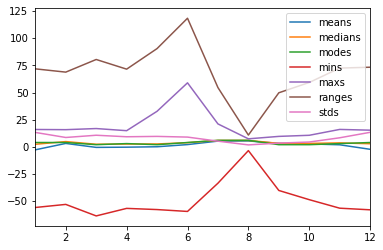

In [7]:
resampled_month_df.means.plot()
resampled_month_df.medians.plot()
resampled_month_df.modes.plot()
resampled_month_df.mins.plot()
resampled_month_df.maxs.plot()
resampled_month_df.ranges.plot()
resampled_month_df.stds.plot()

plt.legend()

## Monthly resample example

In [8]:
resampled_month = cues_ds.goes_cues_diff.where(cues_ds.cloud_flag==0).resample(datetime='1M')

In [9]:
resampled_month_df = resampled_stats(resampled_month, 0)

/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  overwrite_input=overwrite_input)
/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/xarray/core/nputils.py:223: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)
/home/spestana/opt/anaconda3/envs/goes-linux/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


In [10]:
resampled_month_df.head()

,means,medians,modes,counts,maxs,mins,ranges,stds
2017-03-31,-0.675956,1.908380,2.0,669,16.838511,-55.338199,72.176710,10.740207
2017-04-30,-0.003838,2.686340,3.0,582,14.881764,-45.286603,60.168367,9.256338
2017-05-31,1.303331,3.309119,3.0,683,32.726410,-45.730167,78.456577,9.244151
2017-06-30,4.151970,4.623129,6.0,692,58.898572,-59.413712,118.312283,8.191874
2017-07-31,7.376505,6.517395,6.0,309,21.100500,-14.259253,35.359753,3.455523


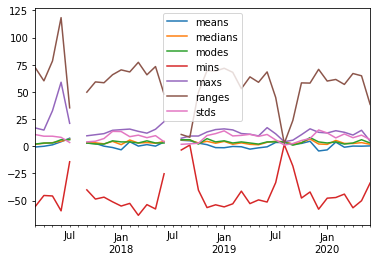

In [11]:
resampled_month_df.means.plot()
resampled_month_df.medians.plot()
resampled_month_df.modes.plot()
resampled_month_df.mins.plot()
resampled_month_df.maxs.plot()
resampled_month_df.ranges.plot()
resampled_month_df.stds.plot()

plt.legend()